In [131]:
from transformers import AutoModelForObjectDetection  # type:ignore

model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

In [132]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

In [133]:
import torch

device = "cpu"
model.to(device)
print("")

In [134]:
from pdf2image import convert_from_path

# Store Pdf with convert_from_path function
images = convert_from_path("./doc.pdf")

for i in range(len(images)):

    # Save pages as images in the pdf
    images[i].save("page" + str(i) + ".jpg", "JPEG")

./page38.jpg


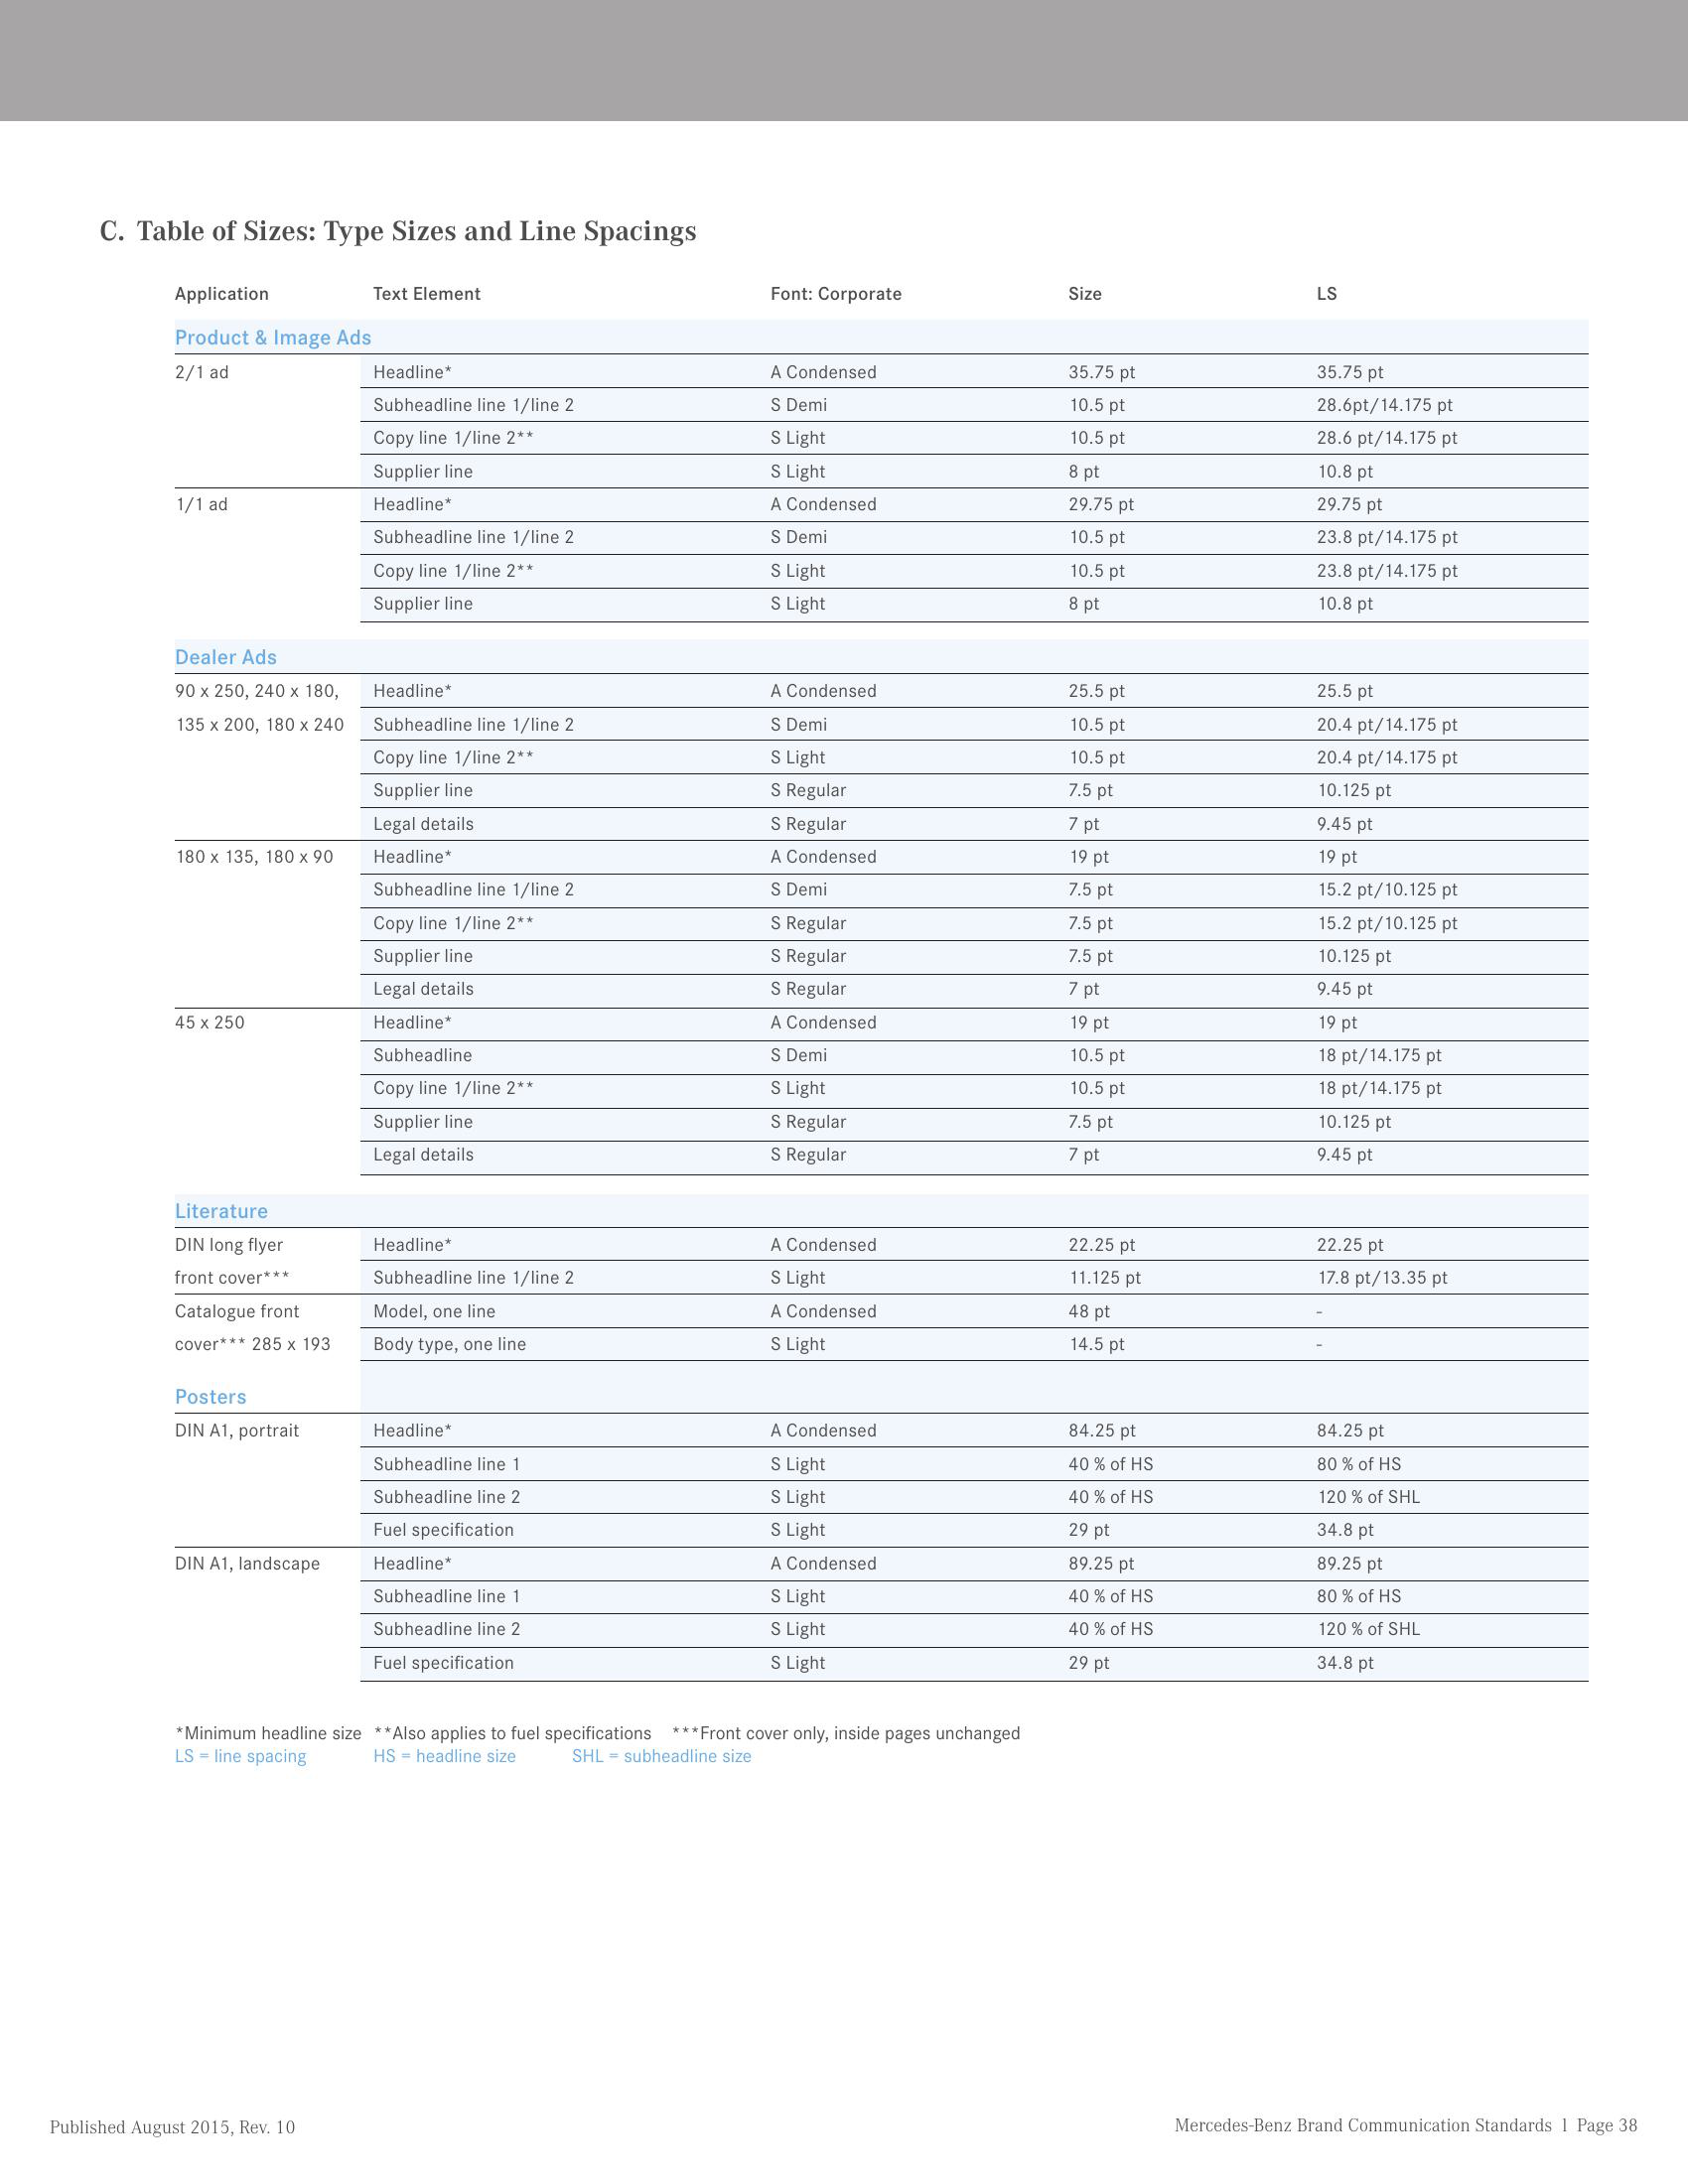

In [135]:
from huggingface_hub import hf_hub_download
from PIL import Image

# let's load an example image
file_path = "./page38.jpg"
print(file_path)
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(1 * width), (int(1 * height)))))

In [136]:
from torchvision import transforms


class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale * width)), int(round(scale * height))))

        return resized_image


detection_transform = transforms.Compose(
    [MaxResize(800), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

In [137]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 618])


In [138]:
with torch.no_grad():
    outputs = model(pixel_values)

In [139]:
outputs.logits.shape

torch.Size([1, 15, 3])

In [140]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs["pred_boxes"].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == "no object":
            objects.append({"label": class_label, "score": float(score), "bbox": [float(elem) for elem in bbox]})

    return objects

In [141]:
objects = outputs_to_objects(outputs, image.size, id2label)
print(objects)

[{'label': 'table', 'score': 0.9992848038673401, 'bbox': [176.62232971191406, 328.220458984375, 1466.0606689453125, 1689.9241943359375]}]


In [142]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io

    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table["bbox"]

        if det_table["label"] == "table":
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch = "//////"
        elif det_table["label"] == "table rotated":
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch = "//////"
        else:
            continue

        rect = patches.Rectangle(
            bbox[:2], bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=linewidth, edgecolor="none", facecolor=facecolor, alpha=0.1
        )
        ax.add_patch(rect)
        rect = patches.Rectangle(
            bbox[:2],
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=linewidth,
            edgecolor=edgecolor,
            facecolor="none",
            linestyle="-",
            alpha=alpha,
        )
        ax.add_patch(rect)
        rect = patches.Rectangle(
            bbox[:2],
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=0,
            edgecolor=edgecolor,
            facecolor="none",
            linestyle="-",
            hatch=hatch,
            alpha=0.2,
        )
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [
        Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45), label="Table", hatch="//////", alpha=0.3),
        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1), label="Table (rotated)", hatch="//////", alpha=0.3),
    ]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc="upper center", borderaxespad=0, fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis("off")

    if out_path is not None:
        plt.savefig(out_path, bbox_inches="tight", dpi=500)

    return fig

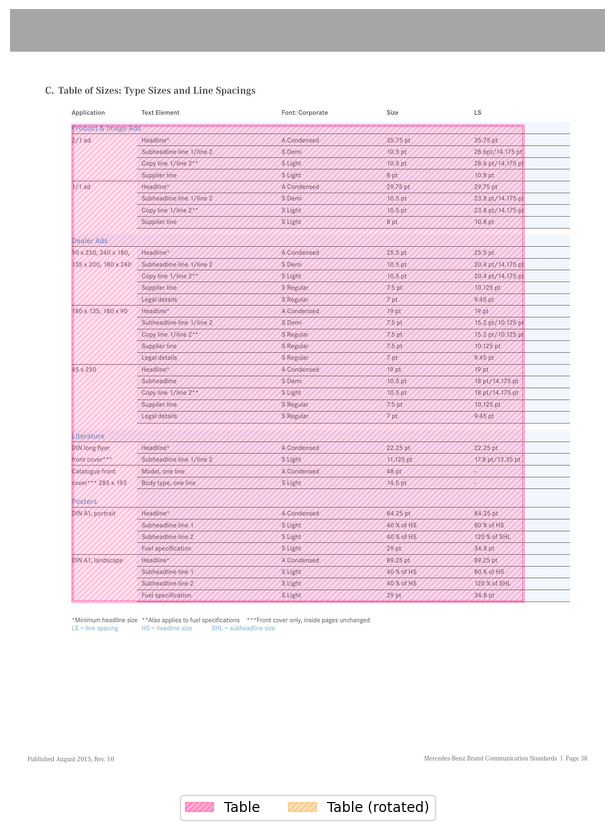

In [143]:
fig = visualize_detected_tables(image, objects)

In [144]:
visualized_image = fig2img(fig)

In [145]:
import iob


def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj["score"] < class_thresholds[obj["label"]]:
            continue

        cropped_table = {}

        bbox = obj["bbox"]
        bbox = [bbox[0] - padding, bbox[1] - padding, bbox[2] + padding, bbox[3] + padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token["bbox"], bbox) >= 0.5]
        for token in table_tokens:
            token["bbox"] = [token["bbox"][0] - bbox[0], token["bbox"][1] - bbox[1], token["bbox"][2] - bbox[0], token["bbox"][3] - bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj["label"] == "table rotated":
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token["bbox"]
                bbox = [cropped_img.size[0] - bbox[3] - 1, bbox[0], cropped_img.size[0] - bbox[1] - 1, bbox[2]]
                token["bbox"] = bbox

        cropped_table["image"] = cropped_img
        cropped_table["tokens"] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [146]:
objects

[{'label': 'table',
  'score': 0.9992848038673401,
  'bbox': [176.62232971191406,
   328.220458984375,
   1466.0606689453125,
   1689.9241943359375]}]

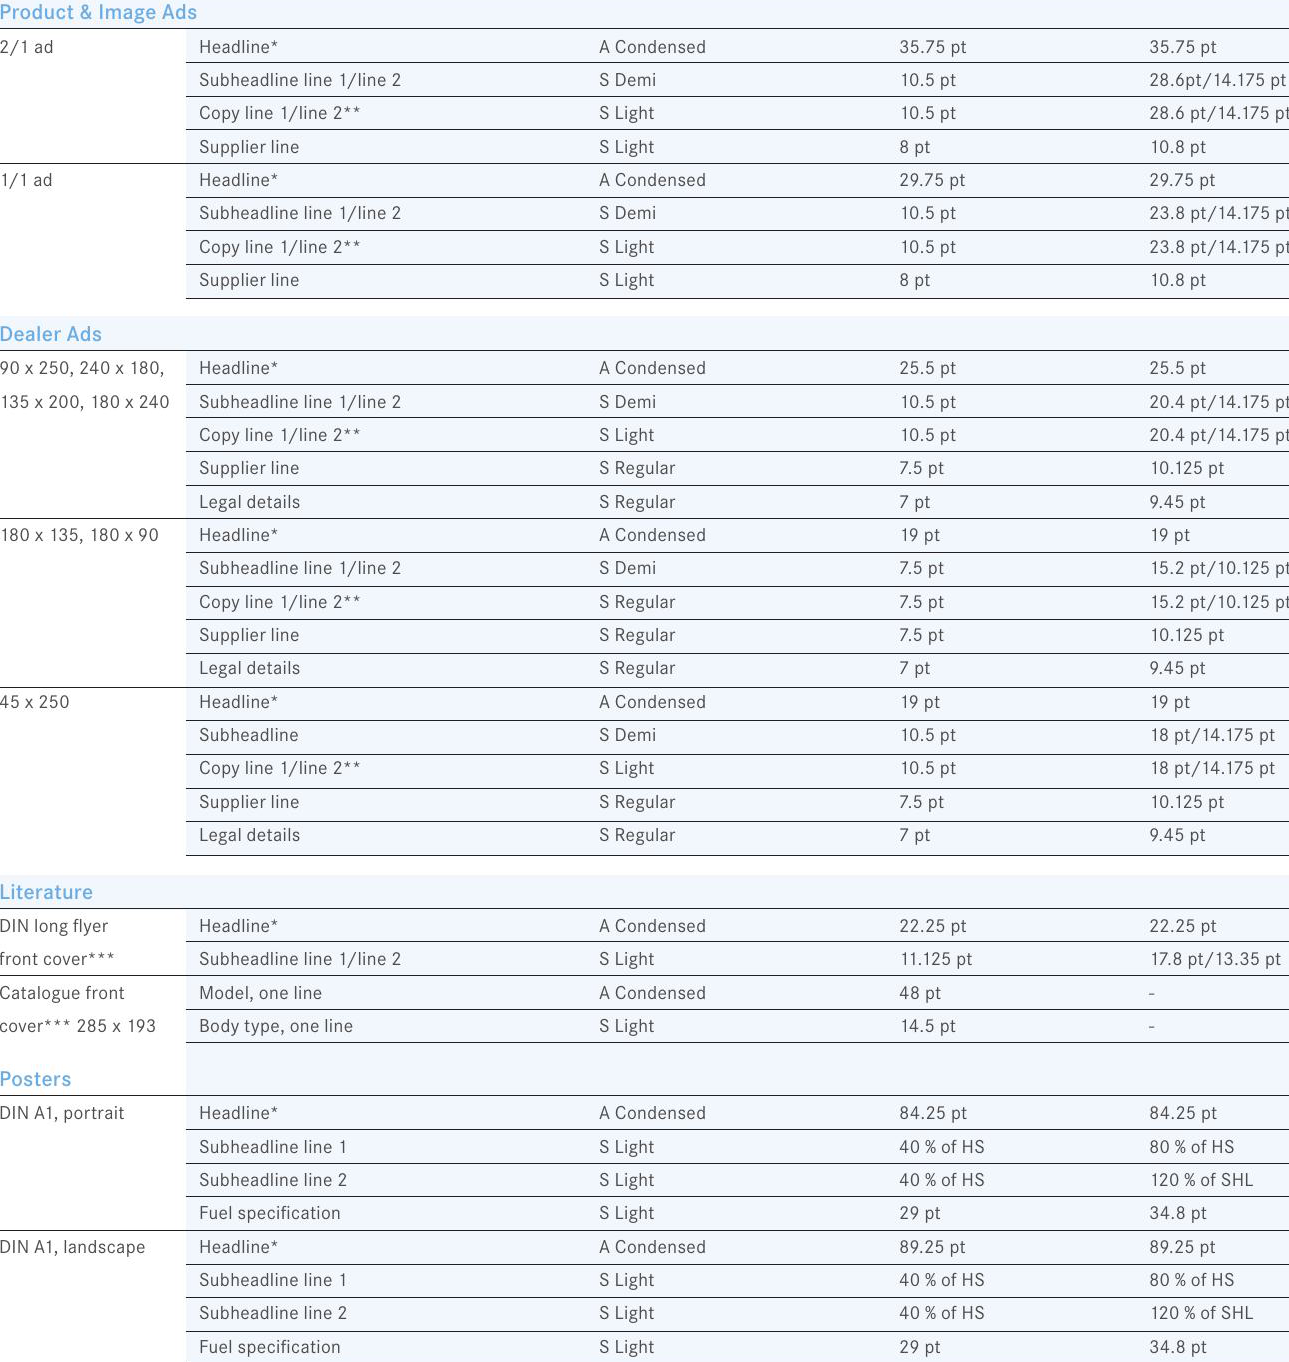

In [147]:
tokens = []
detection_class_thresholds = {"table": 0.5, "table rotated": 0.5, "no object": 10}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]["image"].convert("RGB")
cropped_table

In [148]:
cropped_table.save("table.jpg")

In [149]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

In [150]:
structure_transform = transforms.Compose(
    [MaxResize(800), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

In [151]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 757])


In [152]:
# forward pass
with torch.no_grad():
    outputs = structure_model(pixel_values)

In [153]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table row', 'score': 0.7442381978034973, 'bbox': [-0.0024585723876953125, 826.2841796875, 1288.8349609375, 875.9052124023438]}, {'label': 'table row', 'score': 0.990014910697937, 'bbox': [0.014905095100402832, 373.83837890625, 1288.842529296875, 408.0671081542969]}, {'label': 'table spanning cell', 'score': 0.9620970487594604, 'bbox': [-0.7350939512252808, 514.614990234375, 179.78021240234375, 674.5553588867188]}, {'label': 'table spanning cell', 'score': 0.9000856876373291, 'bbox': [-0.5158392190933228, 158.0201873779297, 181.53660583496094, 312.208251953125]}, {'label': 'table column', 'score': 0.999876856803894, 'bbox': [178.3399658203125, 1.4112191200256348, 502.158447265625, 1356.229248046875]}, {'label': 'table row', 'score': 0.9969761371612549, 'bbox': [0.014866679906845093, 1130.0421142578125, 1288.787841796875, 1163.3587646484375]}, {'label': 'table row', 'score': 0.7048419713973999, 'bbox': [-0.24024862051010132, 634.5841674804688, 1288.5948486328125, 668.48760986

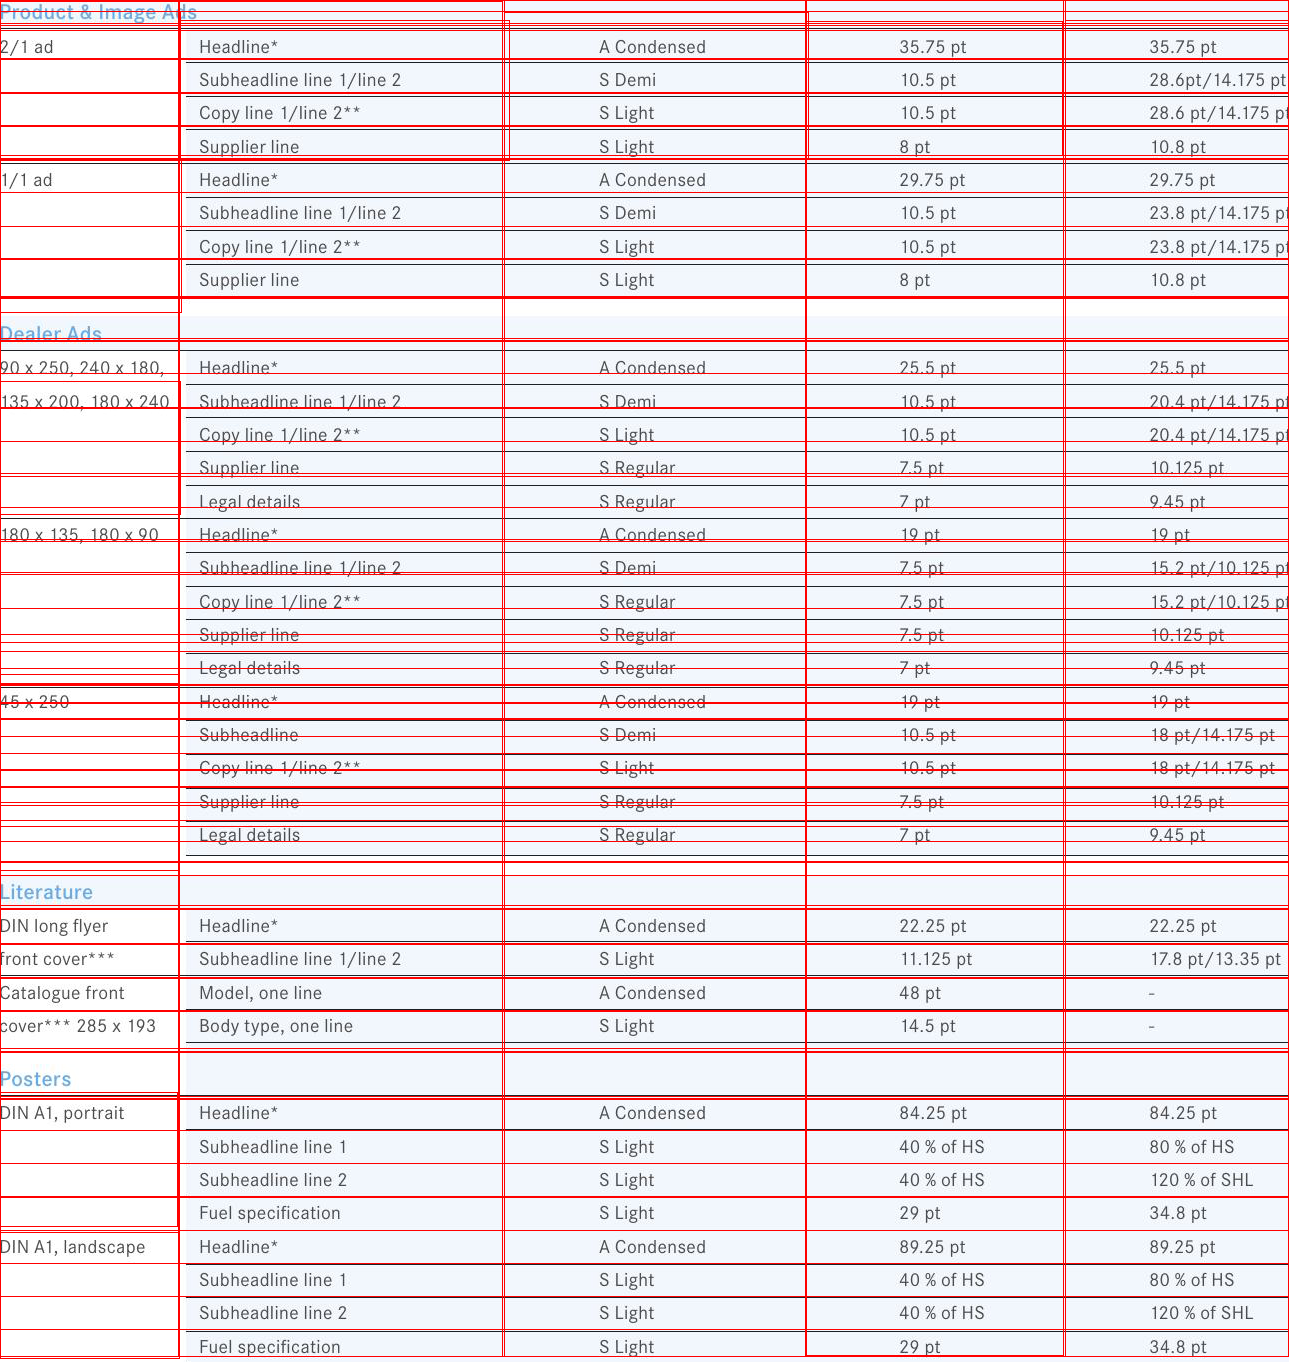

In [154]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [155]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
        raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16, 10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
            xmin, ymin, xmax, ymax = tuple(bbox)

            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
            text = f'{cell["label"]}: {score:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))
            plt.axis("off")

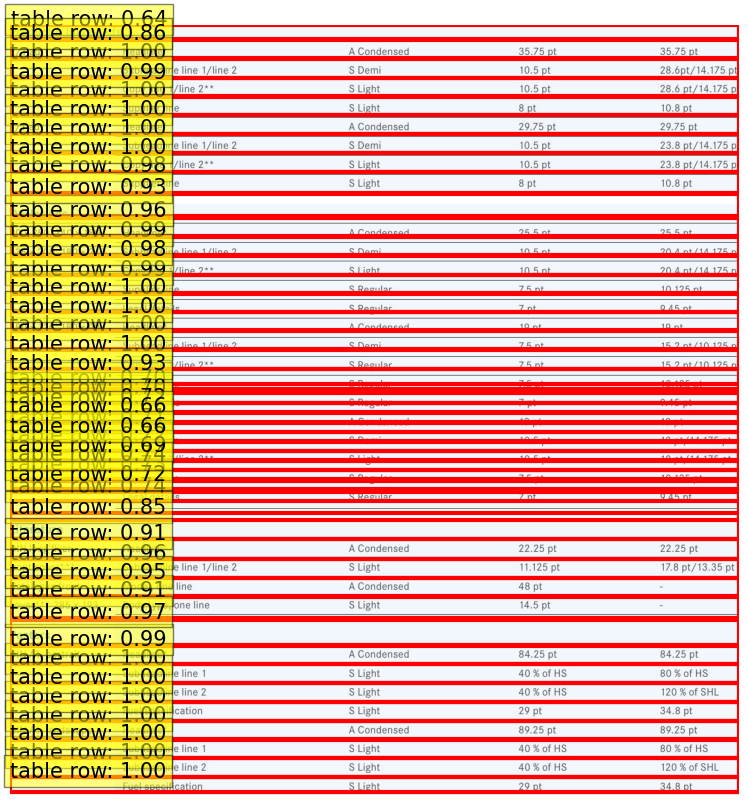

In [156]:
plot_results(cells, class_to_visualize="table row")

In [157]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry["label"] == "table row"]
    columns = [entry for entry in table_data if entry["label"] == "table column"]

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x["bbox"][1])
    columns.sort(key=lambda x: x["bbox"][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column["bbox"][0], row["bbox"][1], column["bbox"][2], row["bbox"][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({"column": column["bbox"], "cell": cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x["column"][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({"row": row["bbox"], "cells": row_cells, "cell_count": len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x["row"][1])

    return cell_coordinates


cell_coordinates = get_cell_coordinates_by_row(cells)

In [158]:
len(cell_coordinates)

45

In [159]:
len(cell_coordinates[0]["cells"])

5

In [160]:
for row in cell_coordinates:
    print(row["cells"])

[{'column': [-0.2576795220375061, 1.3503735065460205, 179.7306365966797, 1356.6868896484375], 'cell': [-0.2576795220375061, -0.08252102136611938, 179.7306365966797, 23.95858383178711]}, {'column': [178.3399658203125, 1.4112191200256348, 502.158447265625, 1356.229248046875], 'cell': [178.3399658203125, -0.08252102136611938, 502.158447265625, 23.95858383178711]}, {'column': [504.2091064453125, 0.31543081998825073, 806.261474609375, 1356.025146484375], 'cell': [504.2091064453125, -0.08252102136611938, 806.261474609375, 23.95858383178711]}, {'column': [805.128662109375, 0.3211541175842285, 1063.5853271484375, 1355.7071533203125], 'cell': [805.128662109375, -0.08252102136611938, 1063.5853271484375, 23.95858383178711]}, {'column': [1065.1796875, 0.6717771291732788, 1289.256591796875, 1356.1063232421875], 'cell': [1065.1796875, -0.08252102136611938, 1289.256591796875, 23.95858383178711]}]
[{'column': [-0.2576795220375061, 1.3503735065460205, 179.7306365966797, 1356.6868896484375], 'cell': [-0

In [161]:
import csv

import easyocr
import numpy as np
from tqdm.auto import tqdm

reader = easyocr.Reader(["en"])  # this needs to run only once to load the model into memory


def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
        row_text = []
        for cell in row["cells"]:
            # crop cell out of image
            cell_image = np.array(cropped_table.crop(cell["cell"]))
            # apply OCR
            result = reader.readtext(np.array(cell_image))
            if len(result) > 0:
                # print([x[1] for x in list(result)])
                text = " ".join([x[1] for x in result])
                row_text.append(text)

        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)

        data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
            row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data


data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

100%|██████████| 45/45 [00:01<00:00, 44.91it/s]

Max number of columns: 5
['Product & Image', 'Js', '', '', '']
['2/1ad', 'Headline', 'A Condensed', '35.75 pt', '35.75 pt']
['Subheadline line 1/line 2', 'S Demi', '10.5 pt', '28.6pt/14.175 pt', '']
['line 1/line 2** Copy', 'S Light', '10.5 pt', '28.6 pt/14.175 pt', '']
['Supplier line', 'S Light', '8 pt', '10.8 pt', '']
['1/1ad', 'Headline', 'A Condensed', '29.75 pt', '29.75 pt']
['Subheadline line 1/line 2', 'S Demi', '10.5 pt', '23.8 pt/14.175 pi', '']
['Copy line 1/line 2**', 'S Light', '10.5 pt', '23.8 pt/14.175 pt', '']
['Supplier line', 'S Light', '8 pt', '10.8 pt', '']
['Dealer Ads', '', '', '', '']
['90 > 250 240 * 180', 'Headline', 'Condensed', '25 5 nt', '25 5 nt']
['135 * 200 180', 'Subheadline line 1 /line', '10.5 nt', '20 4 nt /14 175 nt', '']
['Copv line 1/line 2* *', 'S Light', '10.5 pt', '20.4 pt/14.175 pl', '']
['Supplier line', 'S Regular', '7.5 pt', '10.125 pt', '']
['egal detaile', 'S Regular', '0 45 nt', '', '']
['180 * 135 180 * 90', 'Headline*', 'Condensed', '',